In [1]:
library(tidyverse)
library(dplyr)
library(car)
library(corrplot)
library(pROC)
library(MLmetrics)
library(rpart)
library(rpart.plot) 
library(randomForest)
library(varImp)
library(gbm)
library(caret)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
Warning message:
"package 'ggplot2' was built under R version 4.2.2"
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
"package 'car' was built under R version 4.2.2"
Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some


Warning message:
"

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data <- read.csv(file = url, header = FALSE,
                 col.names = c("ID","clump_thickness", "uniformity_size", "uniformity_shape", "marginal_adhesion", "single_epit helial_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli","mitoses", "diagnosis"))

In [3]:
str(data)

'data.frame':	699 obs. of  11 variables:
 $ ID                          : int  1000025 1002945 1015425 1016277 1017023 1017122 1018099 1018561 1033078 1033078 ...
 $ clump_thickness             : int  5 5 3 6 4 8 1 2 2 4 ...
 $ uniformity_size             : int  1 4 1 8 1 10 1 1 1 2 ...
 $ uniformity_shape            : int  1 4 1 8 1 10 1 2 1 1 ...
 $ marginal_adhesion           : int  1 5 1 1 3 8 1 1 1 1 ...
 $ single_epit.helial_cell_size: int  2 7 2 3 2 7 2 2 2 2 ...
 $ bare_nuclei                 : chr  "1" "10" "2" "4" ...
 $ bland_chromatin             : int  3 3 3 3 3 9 3 3 1 2 ...
 $ normal_nucleoli             : int  1 2 1 7 1 7 1 1 1 1 ...
 $ mitoses                     : int  1 1 1 1 1 1 1 1 5 1 ...
 $ diagnosis                   : int  2 2 2 2 2 4 2 2 2 2 ...


In [4]:
data <- data[data$bare_nuclei != "?",] %>% mutate(bare_nuclei = as.integer(as.character((bare_nuclei))))

In [5]:
data <- data %>% mutate(diagnosis = ifelse(diagnosis == 2, 0, 1),
                        diagnosis = as.factor(diagnosis))


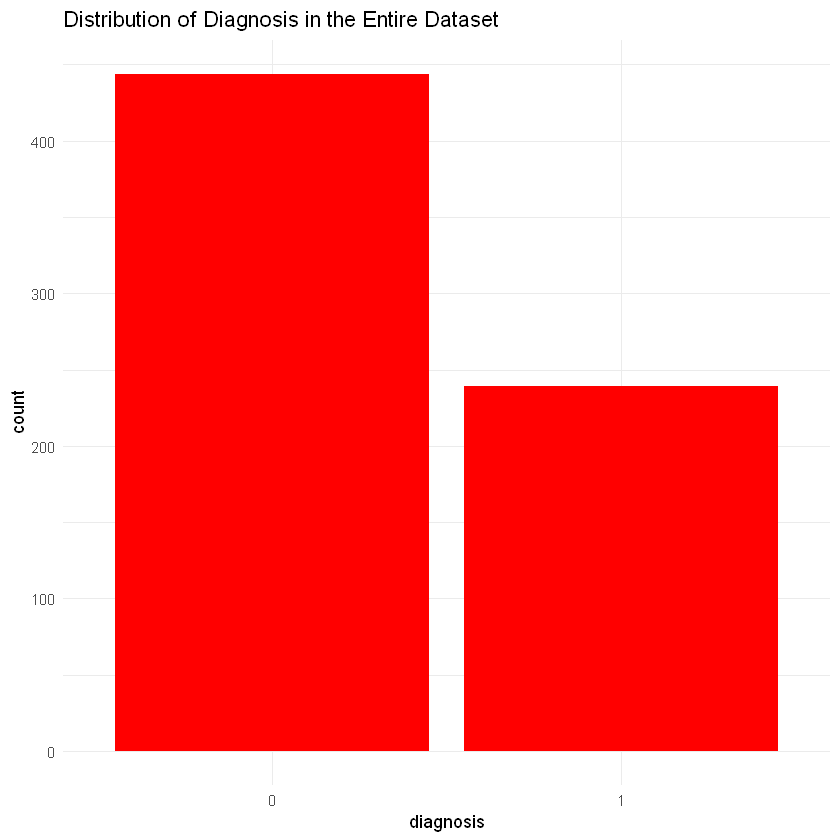

In [6]:
ggplot(data, aes(x = diagnosis)) +
  geom_bar(fill = "red") +
  ggtitle("Distribution of Diagnosis in the Entire Dataset") +
  theme_minimal() +
  theme(legend.position = "none")

In [7]:
summary(data$diagnosis)

0   1 
444 239

In [8]:
head(data)

,ID,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epit.helial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,diagnosis
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,1000025,5,1,1,1,2,1,3,1,1,0
2,1002945,5,4,4,5,7,10,3,2,1,0
3,1015425,3,1,1,1,2,2,3,1,1,0
4,1016277,6,8,8,1,3,4,3,7,1,0
5,1017023,4,1,1,3,2,1,3,1,1,0
6,1017122,8,10,10,8,7,10,9,7,1,1


In [9]:
data$diagnosis <- as.factor(data$diagnosis)
table(data$diagnosis)


  0   1 
444 239 

In [10]:
set.seed(222)
ind <- sample(2, nrow(data), replace = TRUE, prob = c(0.7, 0.3))
train <- data[ind==1,]
test <- data[ind==2,]

In [11]:
head(train)

,ID,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epit.helial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,diagnosis
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
2,1002945,5,4,4,5,7,10,3,2,1,0
3,1015425,3,1,1,1,2,2,3,1,1,0
4,1016277,6,8,8,1,3,4,3,7,1,0
7,1018099,1,1,1,1,2,10,3,1,1,0
8,1018561,2,1,2,1,2,1,3,1,1,0
9,1033078,2,1,1,1,2,1,1,1,5,0


In [12]:
head(test)

,ID,clump_thickness,uniformity_size,uniformity_shape,marginal_adhesion,single_epit.helial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,diagnosis
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,1000025,5,1,1,1,2,1,3,1,1,0
5,1017023,4,1,1,3,2,1,3,1,1,0
6,1017122,8,10,10,8,7,10,9,7,1,1
14,1043999,1,1,1,1,2,3,3,1,1,0
15,1044572,8,7,5,10,7,9,5,5,4,1
21,1054590,7,3,2,10,5,10,5,4,4,1


In [13]:
rf <- randomForest(diagnosis~., data=train, proximity=TRUE) 
print(rf)



Call:
 randomForest(formula = diagnosis ~ ., data = train, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.89%
Confusion matrix:
    0   1 class.error
0 311   8  0.02507837
1   6 160  0.03614458


In [14]:
p1 <- predict(rf, train)
confusionMatrix(p1, train$ diagnosis)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 319   0
         1   0 166
                                     
               Accuracy : 1          
                 95% CI : (0.9924, 1)
    No Information Rate : 0.6577     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.6577     
         Detection Rate : 0.6577     
   Detection Prevalence : 0.6577     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [15]:
p2 <- predict(rf, test)
confusionMatrix(p2, test$diagnosis)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 121   2
         1   4  71
                                          
               Accuracy : 0.9697          
                 95% CI : (0.9352, 0.9888)
    No Information Rate : 0.6313          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9353          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9680          
            Specificity : 0.9726          
         Pos Pred Value : 0.9837          
         Neg Pred Value : 0.9467          
             Prevalence : 0.6313          
         Detection Rate : 0.6111          
   Detection Prevalence : 0.6212          
      Balanced Accuracy : 0.9703          
                                          
       'Positive' Class : 0               
                              

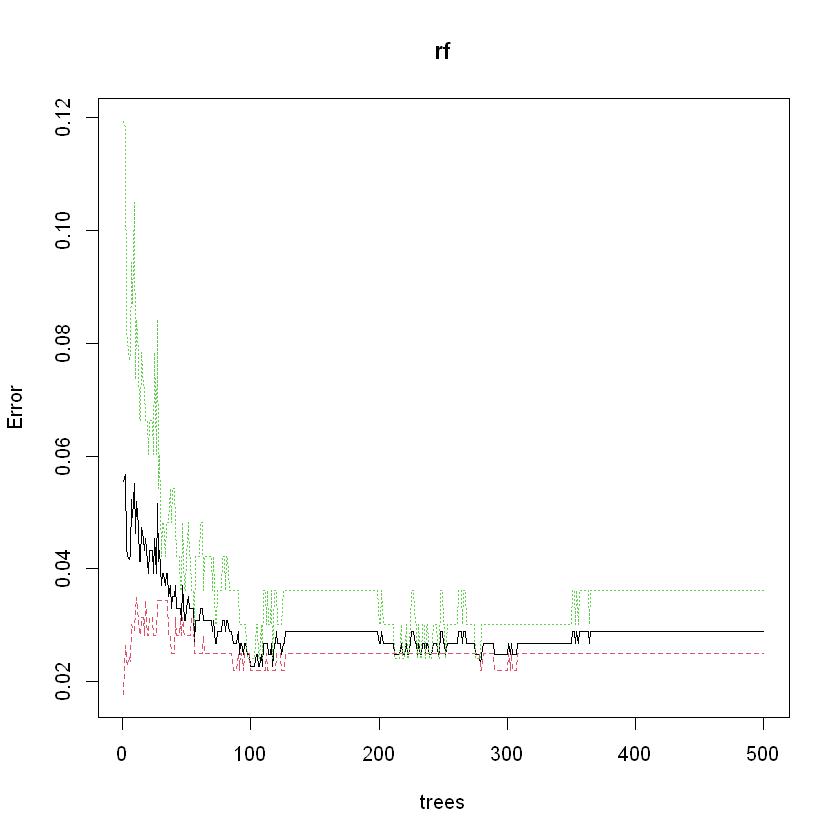

In [16]:
plot(rf)

mtry = 3  OOB error = 3.354967 
Searching left ...
mtry = 6 	OOB error = 3.251899 
0.03072082 0.05 
Searching right ...
mtry = 1 	OOB error = 3.391553 
-0.01090499 0.05 


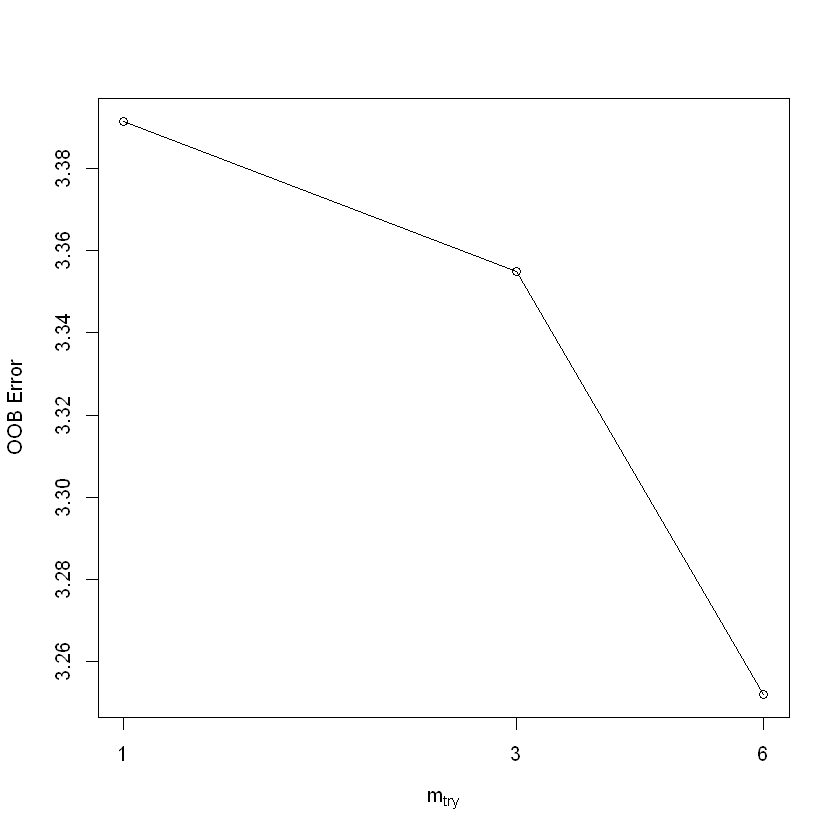

In [17]:
t <- tuneRF(train[,-5], train[,5],
       stepFactor = 0.5,
       plot = TRUE,
       ntreeTry = 150,
       trace = TRUE,
       improve = 0.05
           )

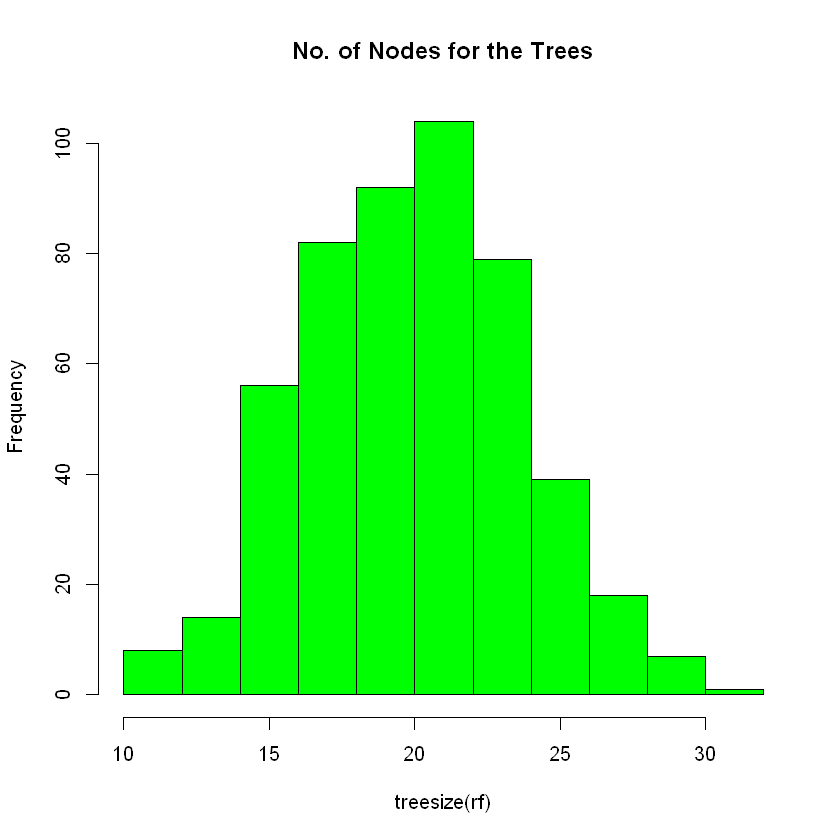

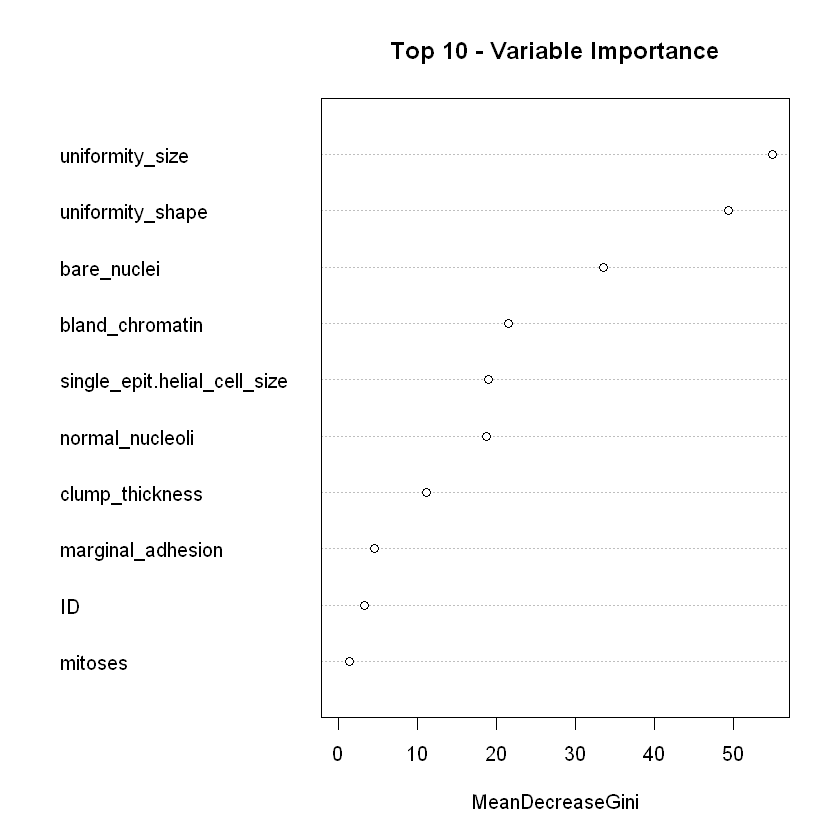

In [18]:
hist(treesize(rf),
     main = "No. of Nodes for the Trees",
     col = "green")

varImpPlot(rf,
           sort = T,
           n.var = 10,
           main = "Top 10 - Variable Importance")


In [19]:
importance(rf)


,MeanDecreaseGini
ID,3.226504
clump_thickness,11.164713
uniformity_size,54.975724
uniformity_shape,49.483330
marginal_adhesion,4.608598
single_epit.helial_cell_size,18.944837
bare_nuclei,33.628732
bland_chromatin,21.488753
normal_nucleoli,18.774732
mitoses,1.366920


In [20]:
set.seed (3011)
rf2 <- randomForest (diagnosis ~., data= train , mtry =3, importance = TRUE)
rf2
p2.2 <- predict(rf2, test)
confusionMatrix(p2.2, test$diagnosis)


Call:
 randomForest(formula = diagnosis ~ ., data = train, mtry = 3,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.47%
Confusion matrix:
    0   1 class.error
0 311   8  0.02507837
1   4 162  0.02409639

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 121   2
         1   4  71
                                          
               Accuracy : 0.9697          
                 95% CI : (0.9352, 0.9888)
    No Information Rate : 0.6313          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9353          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9680          
            Specificity : 0.9726          
         Pos Pred Value : 0.9837          
         Neg Pred Value : 0.9467          
             Prevalence : 0.6313          
         Detection Rate : 0.6111          
   Detection Prevalence : 0.6212          
      Balanced Accuracy : 0.9703          
                                          
       'Positive' Class : 0               
                              

[1] 198

[1] 198

[1] -0.7272727

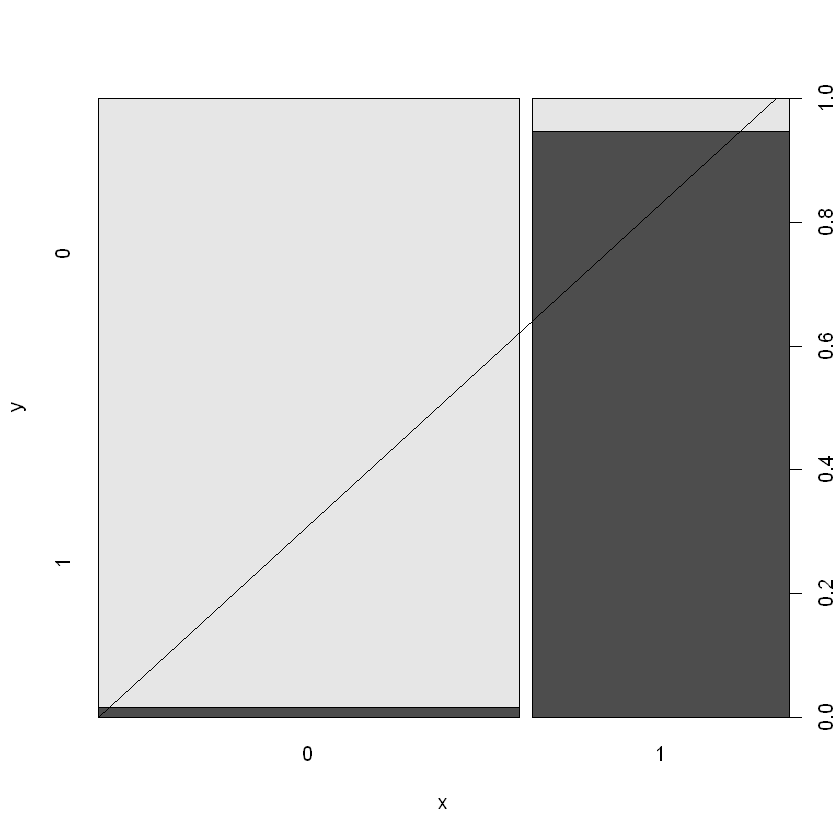

In [21]:
length(p2.2)
length(test$diagnosis)
plot(p2.2,test$diagnosis)
abline (0, 1)
mean((as.numeric(p2.2) - as.numeric(test$diagnosis)^2))

In [22]:
importance(rf2)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
ID,-0.9091007,4.8553753,3.649797,3.165677
clump_thickness,14.7804173,15.0598971,18.188104,11.260549
uniformity_size,16.3343832,15.6898281,21.487079,56.359222
uniformity_shape,10.4318610,18.9568408,21.077244,48.634140
marginal_adhesion,6.4844948,9.8761065,11.368058,5.999196
single_epit.helial_cell_size,8.7736786,9.6134520,12.017751,17.950862
bare_nuclei,13.6400267,22.3027777,22.318978,30.841963
bland_chromatin,8.0181353,15.1780515,15.829043,24.797320
normal_nucleoli,10.9755782,9.5717837,13.523147,17.840535
mitoses,5.4420240,-0.8384047,4.465228,1.152264


Setting levels: control = 0, case = 1

Setting direction: controls < cases



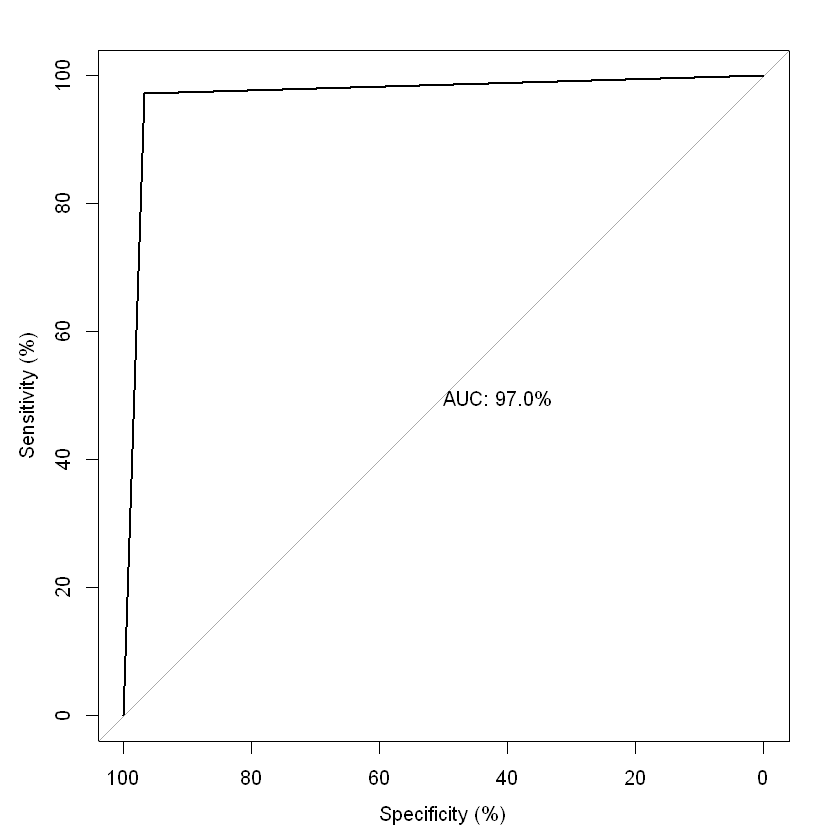

In [23]:
AUCtest <- roc(test$diagnosis, as.numeric(p2.2), percent = TRUE, plot = TRUE, print.auc = TRUE)

In [24]:

round(Accuracy(y_true = test$diagnosis, y_pred = p2.2),3)


[1] 0.97

In [26]:
typeof(test$diagnosis)
typeof(train$diagnosis)

v<-rfcv(data[,-11],data[,11], cv.fold=10, scale='log', step=.5)
#, scale="log", step=1,
#mtry=function(p) max(1, floor(sqrt(p))), recursive=TRUE)


[1] "integer"

[1] "integer"

In [27]:
pred<-v$predicted
pred[[1]]

[1] 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0
 [38] 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0
 [75] 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1
[112] 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1
[149] 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1
[186] 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1
[223] 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1
[260] 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0
[297] 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0
[334] 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
[371] 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1
[408] 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0
[445] 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0
[482] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0
[519] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
[556] 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0
[593] 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
[630] 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1
[667] 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1
Levels: 0 1

In [28]:
confusionMatrix(data[,11],pred[[1]])

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 432  12
         1   6 233
                                          
               Accuracy : 0.9736          
                 95% CI : (0.9587, 0.9843)
    No Information Rate : 0.6413          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9424          
                                          
 Mcnemar's Test P-Value : 0.2386          
                                          
            Sensitivity : 0.9863          
            Specificity : 0.9510          
         Pos Pred Value : 0.9730          
         Neg Pred Value : 0.9749          
             Prevalence : 0.6413          
         Detection Rate : 0.6325          
   Detection Prevalence : 0.6501          
      Balanced Accuracy : 0.9687          
                                          
       'Positive' Class : 0               
                              